# Guide to tHMM

In [1]:
from lineage.tHMM_utils import getAccuracy, getAIC
from lineage.Lineage_utils import remove_singleton_lineages, remove_unfinished_cells
from lineage.plotting_utils import make_colormap_graph
from lineage.Analyze import Analyze
from lineage.Depth_Two_State_Lineage import Depth_Two_State_Lineage

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

## Creating and analyzing our synthetic lineage

Variables subscripted or prefixed with `MAS` are referring to the first lineage in this heterogeneous lineage, while variables subscripted with `2` are referring to the second lineage. These two lineages are what comprise the _depth two state_ lineage.

In [3]:
T_MAS = 400. # how long the first synthetic lineage runs for
T_2 = 250. # how long the second synthetic lineage runs for
experimentTime = T_MAS + T_2
MASinitCells = [1] # how many initial cells are in the first lineage (has to be one)
MASlocBern = [0.999] # the bernoulli parameter regarding the chance of dividing over dying for the master (first) lineage
MASbeta = [80] # the exponential parameter regarding how long a cell lives [hours]

initCells2 = [1] # how many initial cells are in the second lineage (has to be one)
locBern2 = [0.8] # the bernoulli parameter regarding the change of dividing over dying for the second lineage
beta2 = [20] # the exponential parameter regarding how long a cell lives [hours]

# In general, the above parameters are described as lists because one can have multiple groups of parameters
# to describe their population. For example, one can easily create a population with initCells = [10, 50, 3],
# locBern = [0.8, 0.9, 0.75], beta = [80, 20, 90] to create three distinct populations. That is to say,
# 10+50+3=63 lineages will be created, each tree following their own distribution parameters using the same index
# in the other lists. 

# To create these depth heterogenous lineages, we created the function below that can join one lineage to another
# and also perform the right house-keeping tasks to make sure that the lineages are sufficiently joined, such as
# making sure the correct parent-daughter links exist, the cells in the second lineage recognize the root cell of
# the master lineage tree, etc.

max_lin_length = 200 # for the purpose of visualizing data, we set restrictions on the maximum length and
min_lin_length = 5 # minimum length of the lineage generated
FOM='E' # this just tells the code that we are using an exponential Force of Mortality
X, newLineage, masterLineage, subLineage2 = Depth_Two_State_Lineage(T_MAS, MASinitCells, MASlocBern, T_2, initCells2, locBern2, FOM=FOM, betaExp=MASbeta, betaExp2=beta2)

X1 = remove_singleton_lineages(X) # this removes lineages that are just one cell as they seem to break under the analysus
X2 = remove_unfinished_cells(X1) # this removes cells that lived past the experimental end time

numStates = 2 # need to tell our code how many states we expect to see
_, _, all_states, tHMMobj, _, _ = Analyze(X2, numStates) # this function contains the bulk of our analysis code
# that is, it neatly runs our analysis steps in order

# Visualizing results



Lineage Index: 0
Initial Proabablities: 
[1.4750045e-28 1.0000000e+00]
Transition State Matrix: 
[[0.19145771 0.80854229]
 [0.18619117 0.81380883]]
Emission Parameters: 
[[1.11358575e-13 1.23638845e+01]
 [1.00000000e+00 1.45857397e+01]]
True states: 
[0 0 0 ... 1 1 1]
Viterbi estimated raw states (before state assignment switch): 
[0 0 0 ... 0 1 1]
State assignment after analysis: 
(0, 1)
Viterbi estimated relative states (after state switch): 
[0 0 0 ... 0 1 1]
Accuracy: 
0.7444029850746269


/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


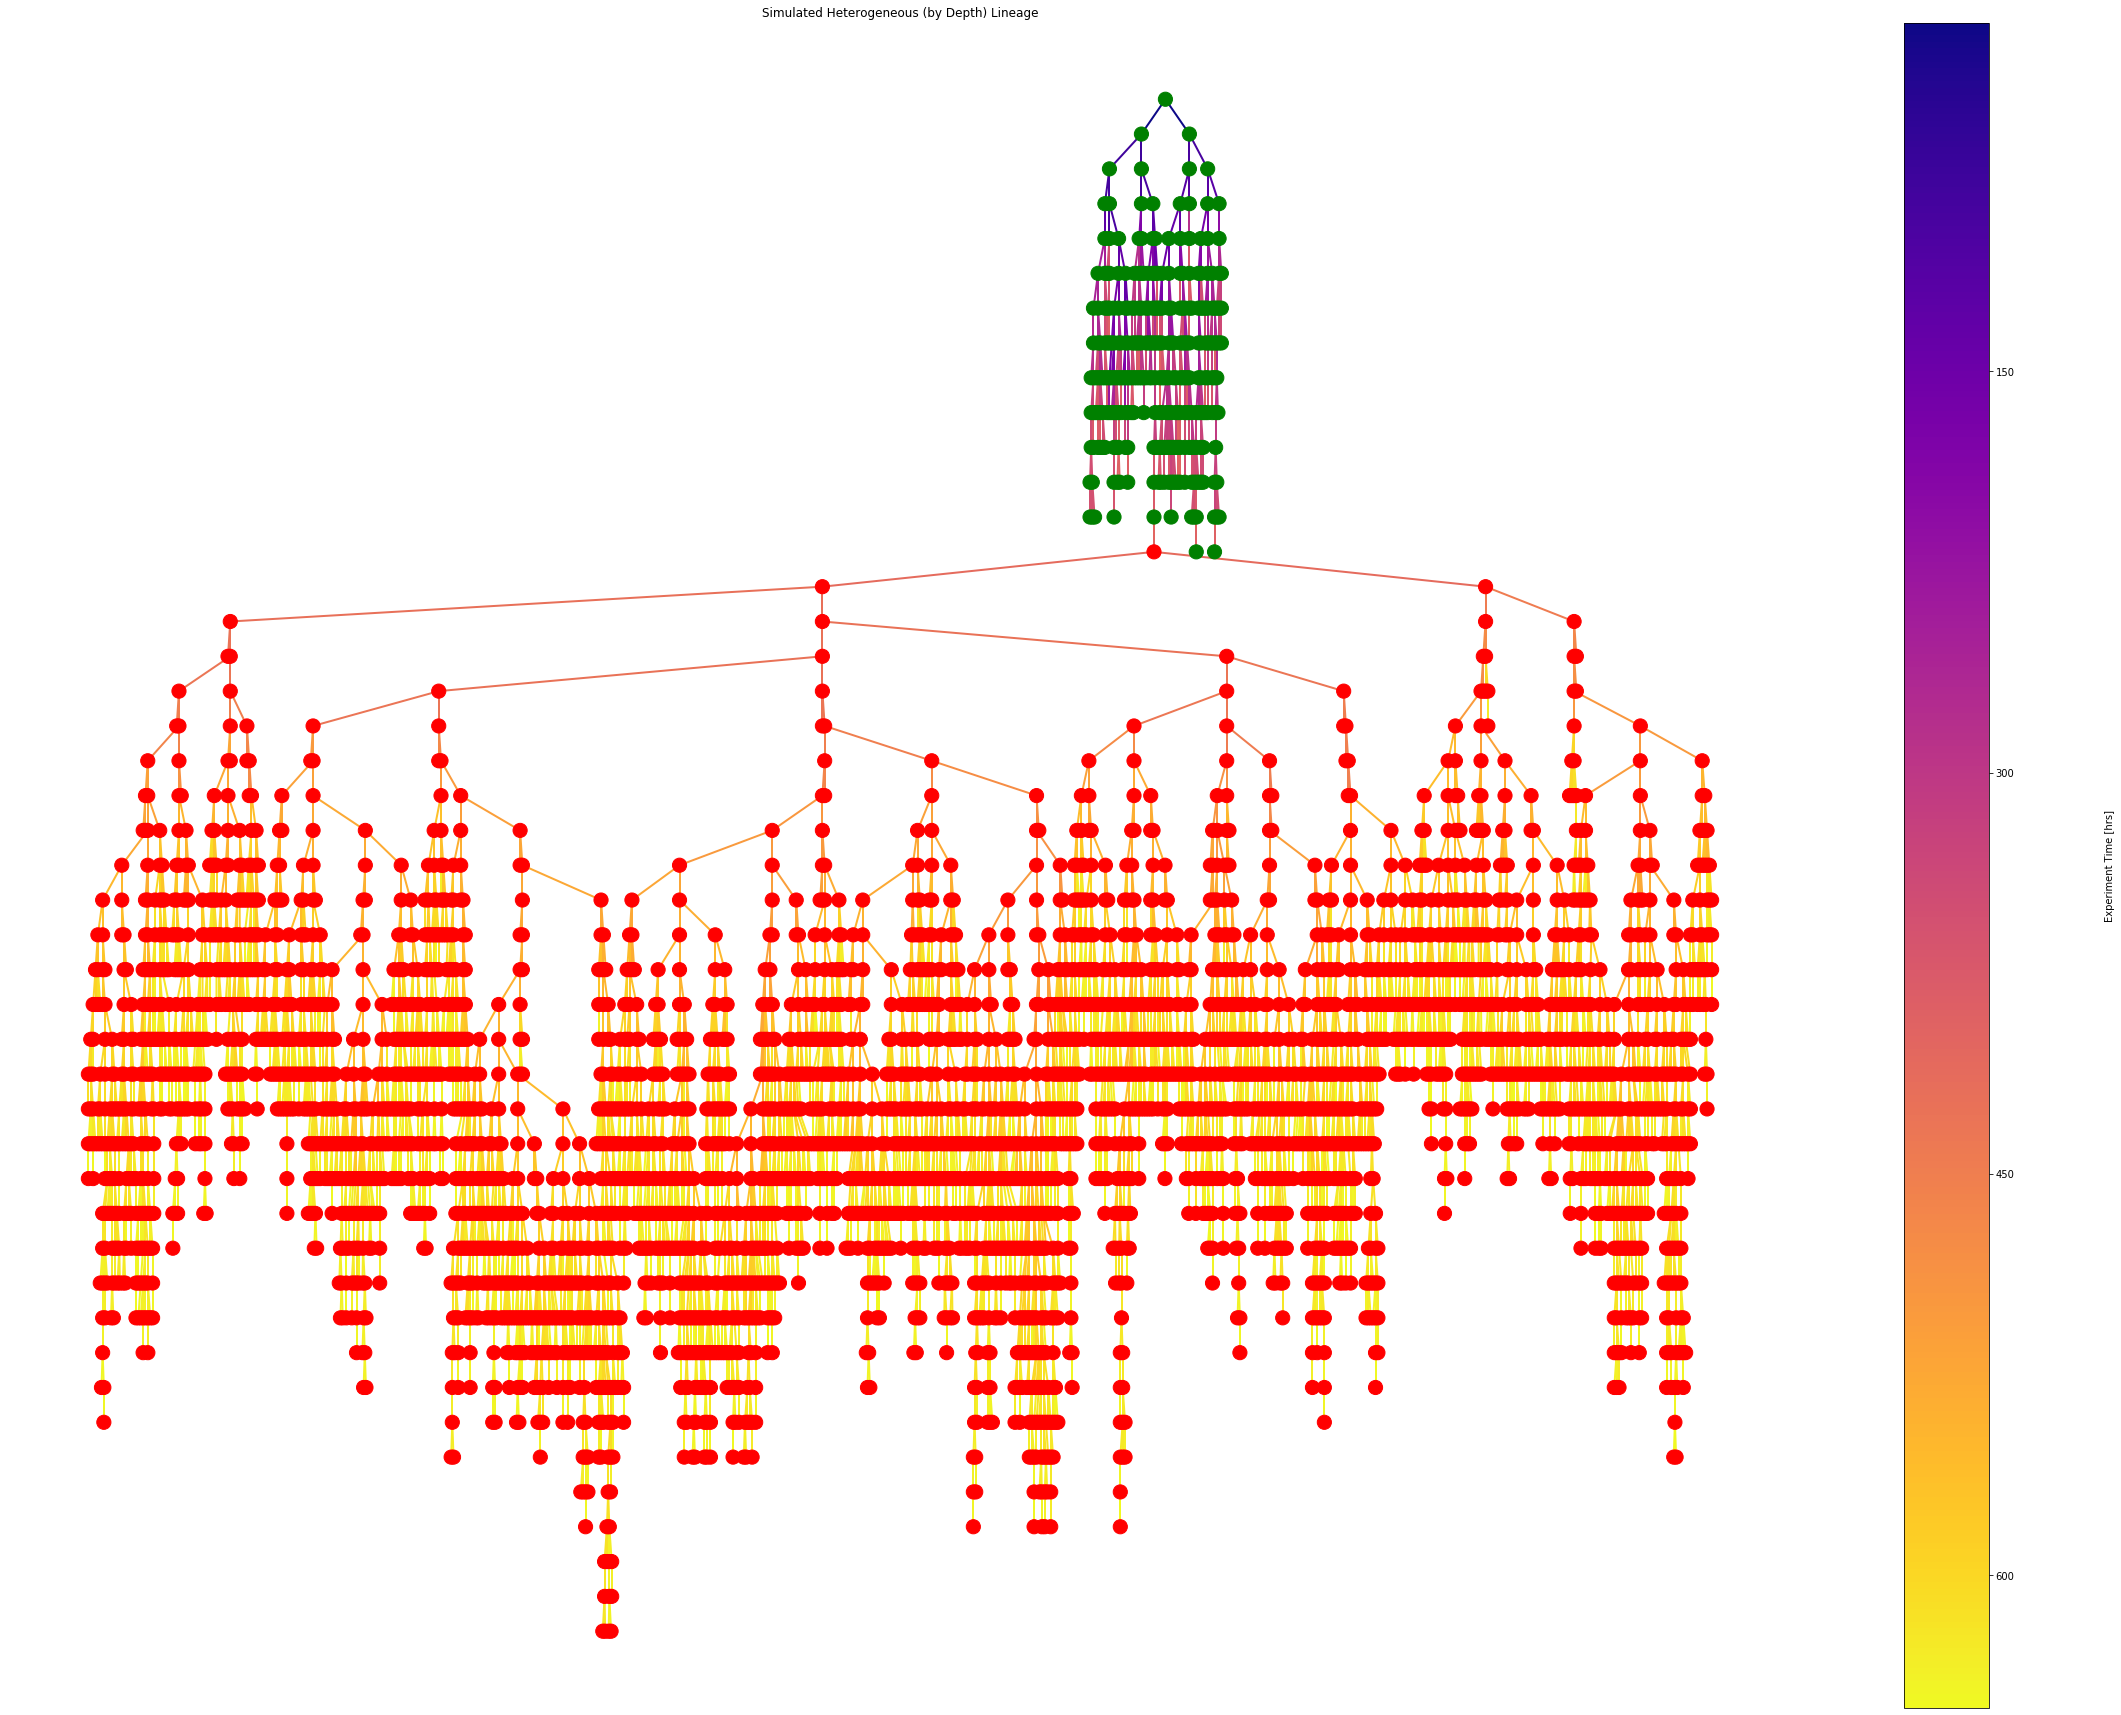

In [4]:
getAccuracy(tHMMobj, all_states, verbose=True) # this function simply runs the state comparison and checks for accuracy
import matplotlib as mpl
from matplotlib import ticker

G, cmap, _ = make_colormap_graph(X2)
M = G.number_of_edges()
edge_weights = [d for (u,v,d) in G.edges.data('weight')]
#pos prog options: neato, dot, twopi, circo (don't use), fdp (don't use), nop (don't use), wc (don't use), acyclic (don't use), gvpr (don't use), gvcolor (don't use), ccomps (don't use), sccmap (don't use), tred (don't use), sfdp (don't use), unflatten (don't use)
pos = graphviz_layout(G, prog='dot', root=0)
plt.figure(figsize=(40,31))
plt.figaspect(1)
node_size = 200
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=cmap, alpha=1)
edges = nx.draw_networkx_edges(G, pos, node_size=node_size, edge_color=edge_weights, edge_cmap=plt.cm.plasma, width=2)

ax = plt.gca()
ax.set_axis_off()
cb = plt.colorbar(edges, ticks=edge_weights)
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label(label=r'Experiment Time [hrs]', labelpad=90)
cb.ax.invert_yaxis()
plt.title('Simulated Heterogeneous (by Depth) Lineage')
plt.rcParams.update({'font.size': 64})
plt.savefig('true.svg')
plt.show()

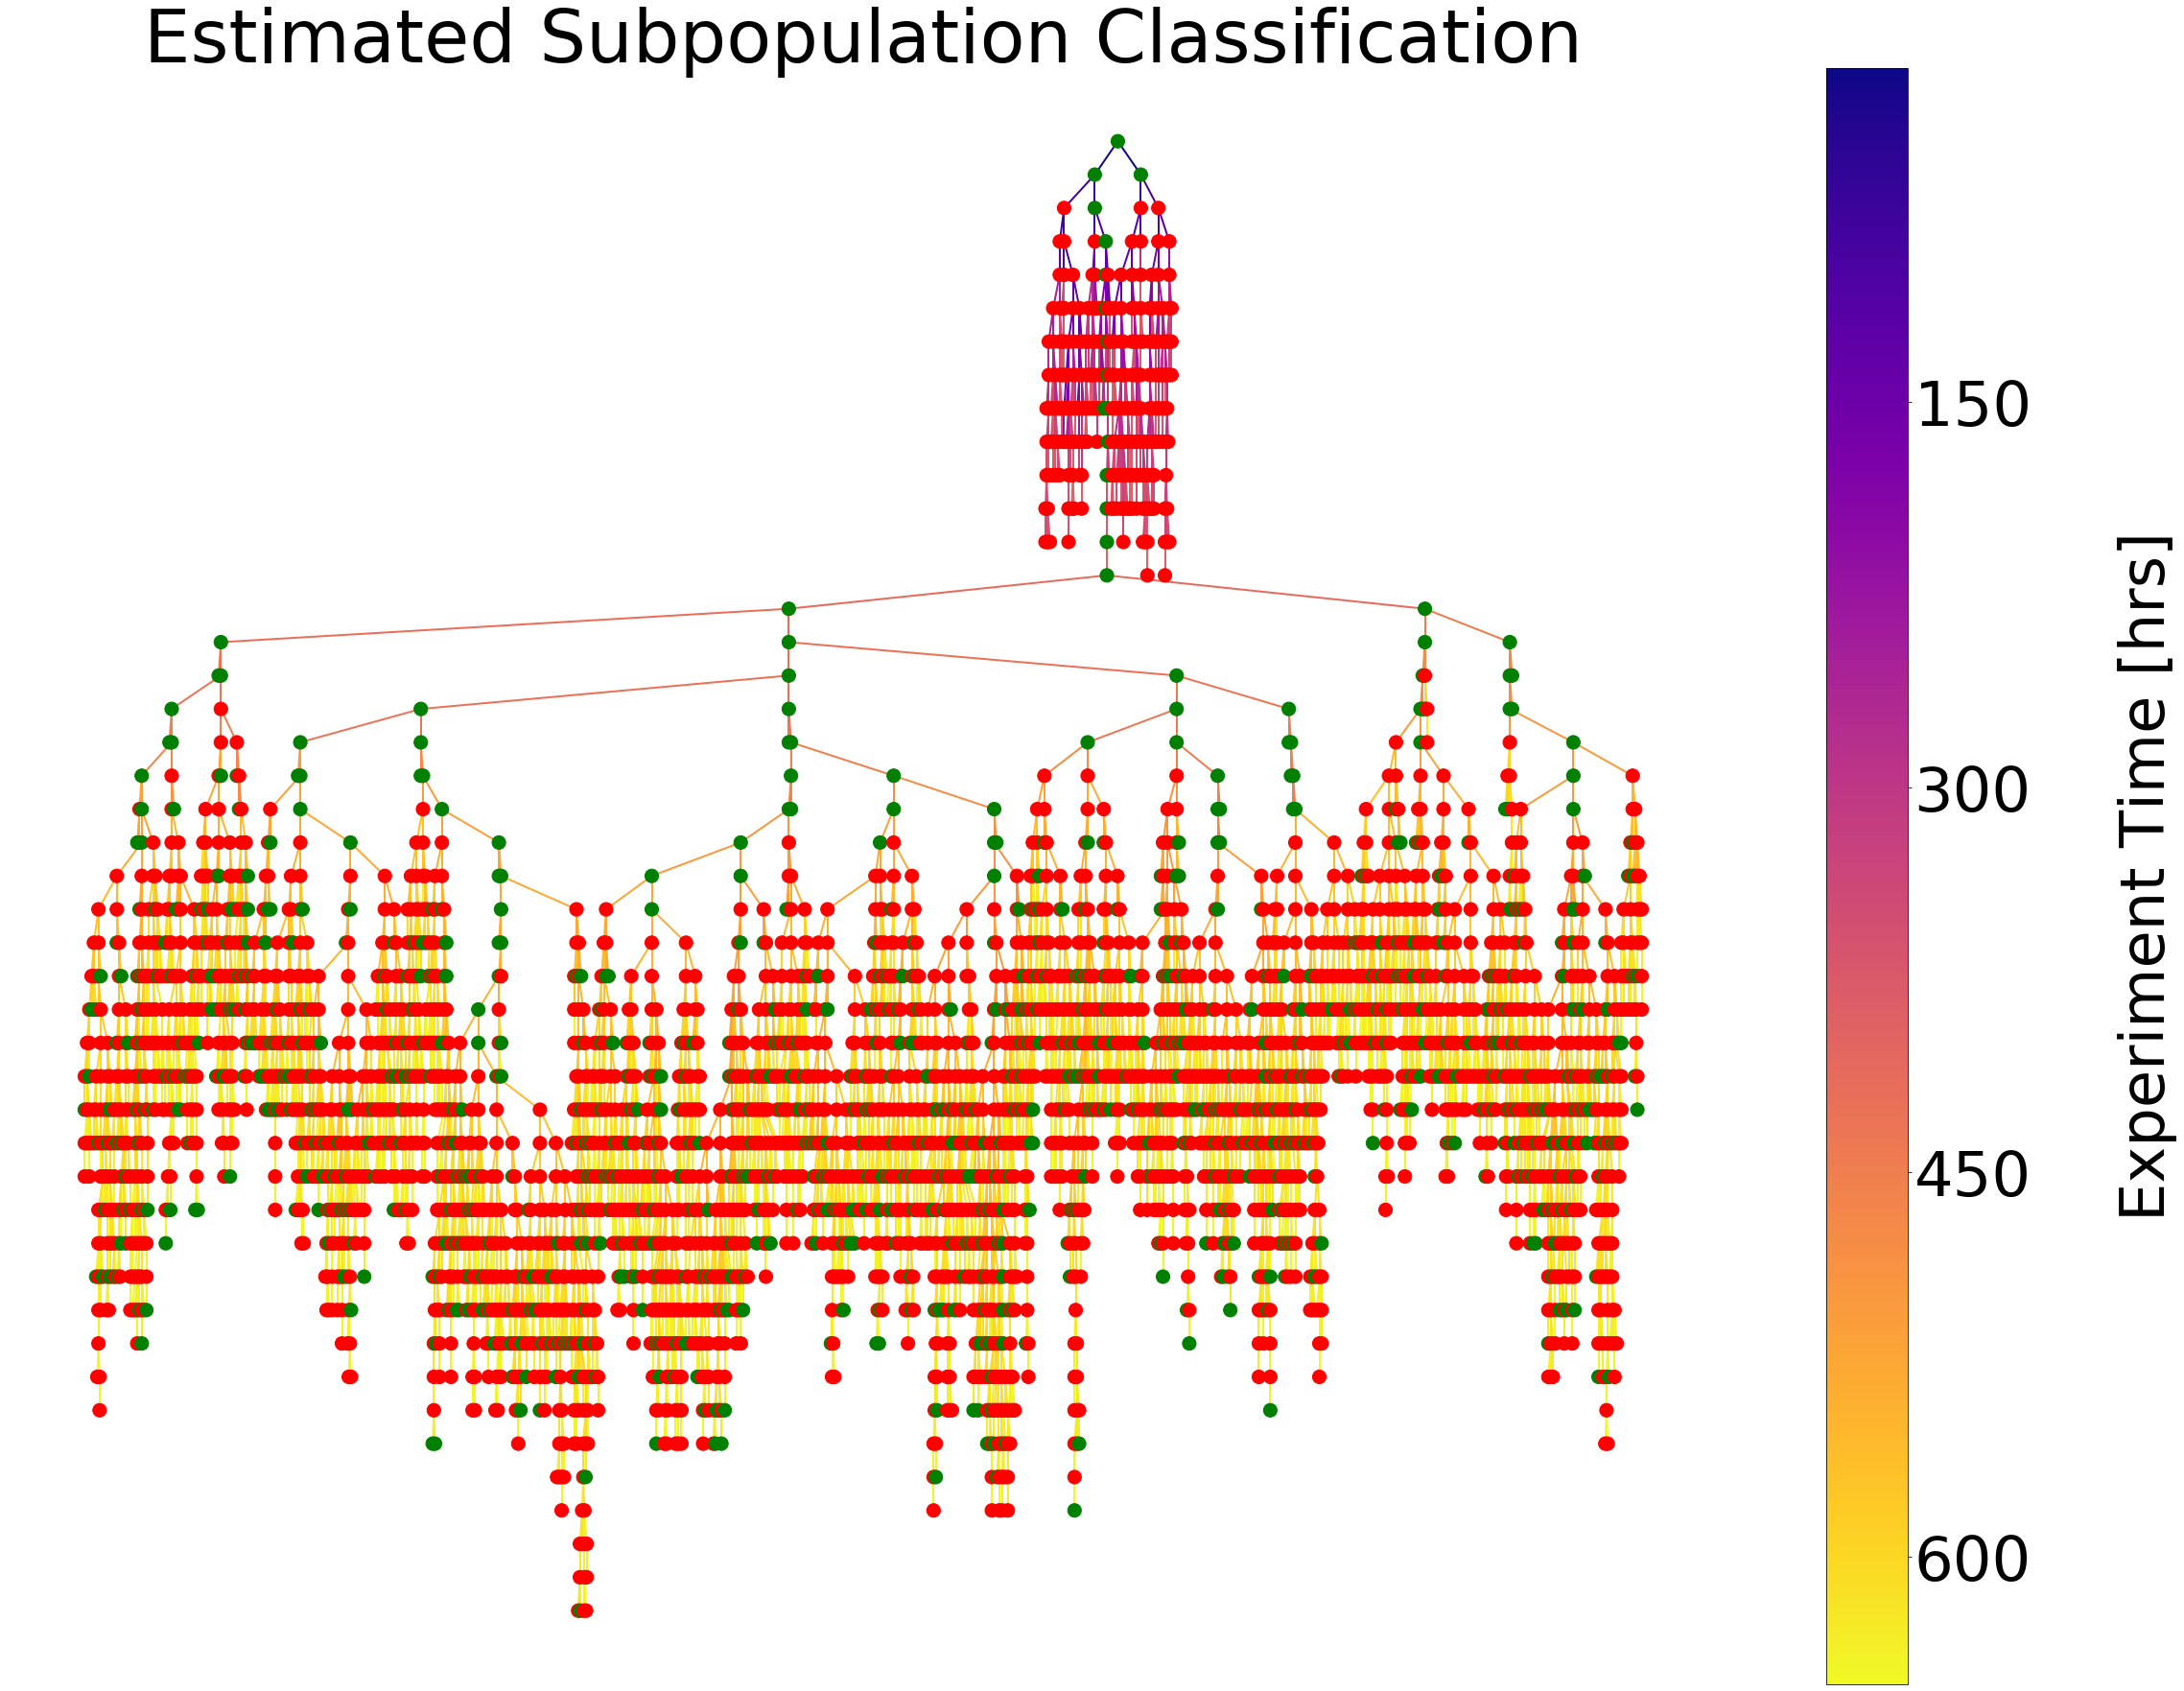

In [5]:
G, cmap, _ = make_colormap_graph(X2, tHMMobj.states[0])
M = G.number_of_edges()
edge_weights = [d for (u,v,d) in G.edges.data('weight')]
#pos prog options: neato, dot, twopi, circo (don't use), fdp (don't use), nop (don't use), wc (don't use), acyclic (don't use), gvpr (don't use), gvcolor (don't use), ccomps (don't use), sccmap (don't use), tred (don't use), sfdp (don't use), unflatten (don't use)
pos = graphviz_layout(G, prog='dot', root=0)
plt.figure(figsize=(40,31))
plt.figaspect(1)
node_size = 200
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=cmap, alpha=1)
edges = nx.draw_networkx_edges(G, pos, node_size=node_size, edge_color=edge_weights, edge_cmap=plt.cm.plasma, width=2)

ax = plt.gca()
ax.set_axis_off()
cb = plt.colorbar(edges, ticks=edge_weights)
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label(label=r'Experiment Time [hrs]', labelpad=90)
cb.ax.invert_yaxis()
plt.title('Estimated Subpopulation Classification')
plt.rcParams.update({'font.size': 64})
plt.savefig('estimated.svg')
plt.show()